High Density Regions can be used to find cross sections across a multi-dimensional space that have the highest concentrations of data points. It can also be used to compute the average value of an aggregate statistic with respect to a target variable.

In [1]:
import matplotlib.pyplot as plt

In [2]:
#the package uses numba compile funtions, it may take a few seconds to load
import kernelml
import numpy as np
import pandas as pd

In [33]:
from sklearn import datasets,mixture

def generate_MoG_data(num_data, means, covariances, weights):
    """ Creates a list of data points """
    num_clusters = len(weights)
    data = []
    k = np.random.choice(len(weights), num_data, p=weights)
    for i in range(len(weights)):
        cnt = np.sum(k==i)
        x = np.random.multivariate_normal(means[i], covariances[i],size=cnt)
        data.append(x)
    return data


def plt_two_dev_clust():
    for k in range(3):
        i,j=0,1
        w1 = init_means[k][i]
        w2 = init_means[k][j]

        k_cov = np.array(init_covariances[k])
        C = np.array([[k_cov[i,i],k_cov[i,j]],[k_cov[j,i],k_cov[j,j]]])

        eVa, eVe = np.linalg.eig(C)
        R, S = eVe, np.diag(np.sqrt(eVa))

        C = np.array([[k_cov[i,i],k_cov[i,j]],[k_cov[j,i],k_cov[j,j]]])

        eVa, eVe = np.linalg.eig(C)
        R, S = eVe, np.diag(np.sqrt(eVa))
        #create circle (points)
        z = np.linspace(0,2*np.pi,100)

        points = np.array([[np.sin(z[i]),np.cos(z[i])] for i in range(z.shape[0]-1)])
        points = np.concatenate([points,points[:1]])

        #1 std away
        T = (S*2).dot(R.T)
        points = points.dot(T)
        points[:,0] = points[:,0]+w1
        points[:,1] = points[:,1]+w2
        plt.plot(points[:,0],points[:,1],color='#17C350')


init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [0, 5]  # mean of cluster 3
]

init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster

X = np.vstack(generate_MoG_data(5000, init_means, init_covariances, init_weights))

In [ ]:
"""
HierarchicalDensityFactorization parameters:

number_of_clusters: The number of clusters
bins_per_dimension: The number of histogram bins across each dimensions. This is used for estimating the kernel density function
smoothing_parameter: Increases the bandwidth of the kernel density estimation
min_leaf_samples: Prunes clusters than have less than the minimum number of samples
alpha: Discount factor, 0<alpha<1

"""

In [39]:
hdf =  kernelml.region_estimator.HierarchicalDensityFactorization(num_clusters=16,
                                                                 bins_per_dimension=61,
                                                                 smoothing_parameter=1.,
                                                                 min_leaf_samples=50,
                                                                 alpha=0.5)

hdf.optimize(X,maxiter=12,realizations=10,number_of_random_simulations=100,verbose=True)

realization 0 loss 8.546120455244655 time 0.606666088104248
realization 1 loss 4.966485808191126 time 0.6150720119476318
realization 2 loss 2.228663618598869 time 0.5829839706420898
realization 3 loss 1.3303770778069461 time 0.5667648315429688
realization 4 loss 1.0675794145384703 time 0.611335039138794
realization 5 loss 0.8740150418373136 time 0.6317570209503174
realization 6 loss 0.7934262490342343 time 0.6263730525970459
realization 7 loss 0.7625996821425547 time 0.6356470584869385
realization 8 loss 0.7417024080517056 time 0.6177139282226562
realization 9 loss 0.7392344707755933 time 0.6588809490203857
0 clusters were not assigned data points

500 data points are unassigned
realization 0 loss 6.931711391647645 time 0.5771896839141846
realization 1 loss 4.980464570950784 time 0.5949199199676514
realization 2 loss 2.2407943688681726 time 0.6159827709197998
realization 3 loss 1.3686436659123917 time 0.6083493232727051
realization 4 loss 0.98842004375791 time 0.610907793045044
realiza

In [ ]:
"""
The plots below show clusters that were not close to the true distribution. 

These clusters are excluded if the number of data points is less than min_leaf_samples
"""

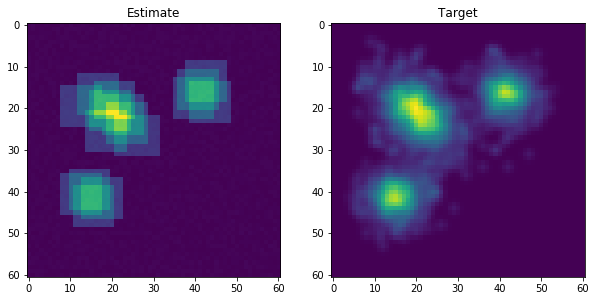

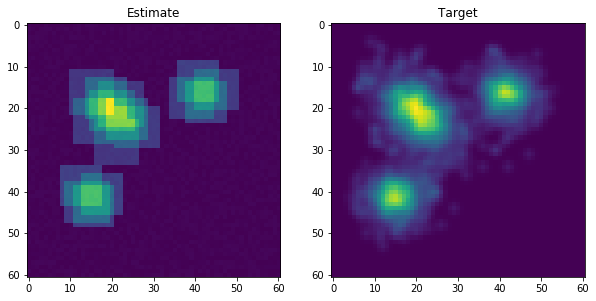

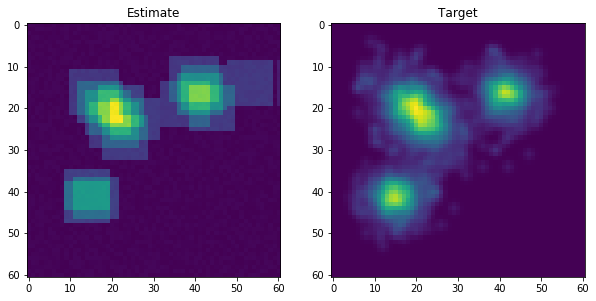

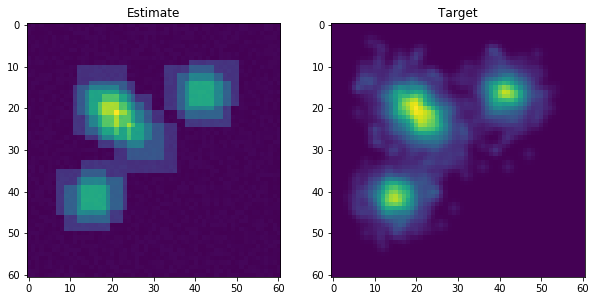

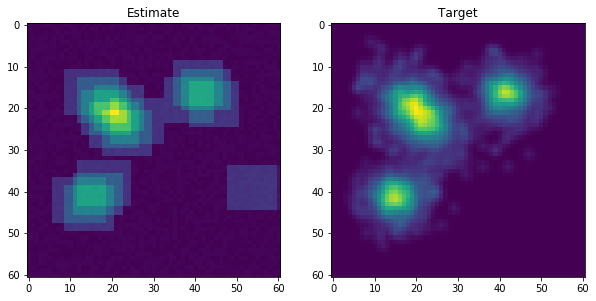

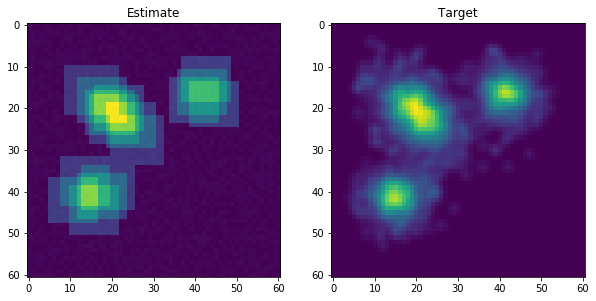

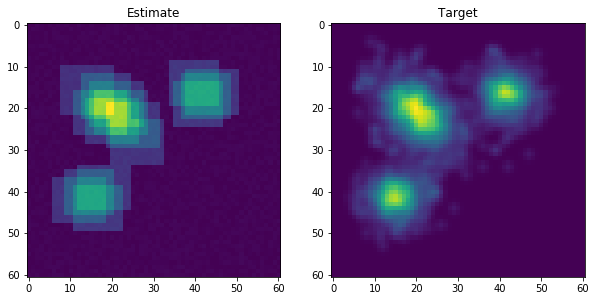

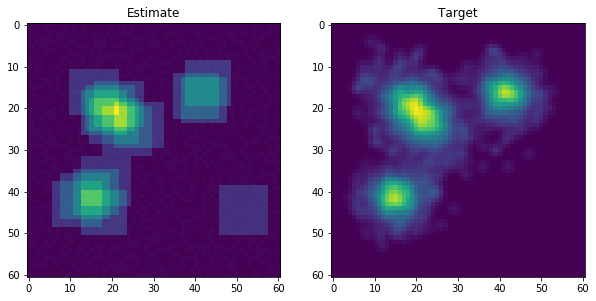

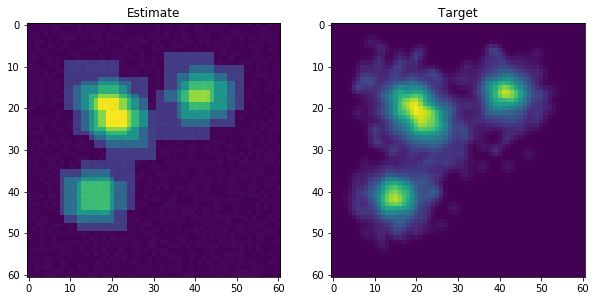

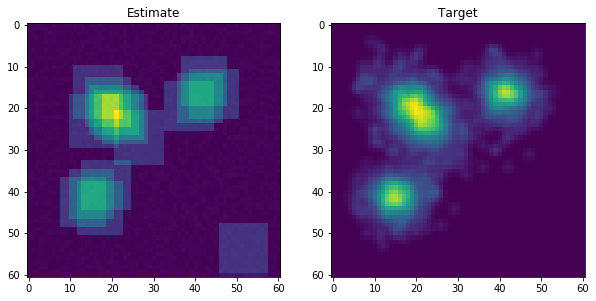

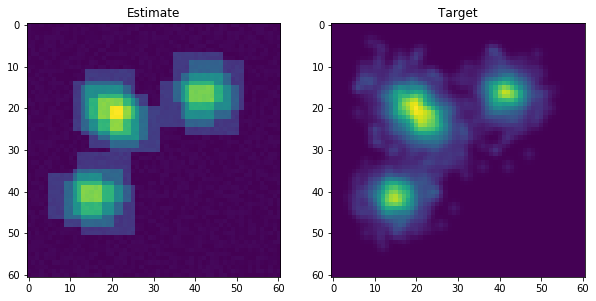

In [45]:
for model in hdf.models:

    count=0
    for i,j in model.dim_combos:
        plt.figure(figsize=(10,10))
        plt.subplot(1,2,1)
        plt.imshow(model.kde_estimate[count])
        plt.title('Estimate')

        plt.subplot(1,2,2)
        plt.imshow(model.kde_target[count])
        plt.title('Target')
        plt.show()
        count+=1

In [41]:
#assignments
A = hdf.assign(X)
#density
D = np.sum(A,axis=1)

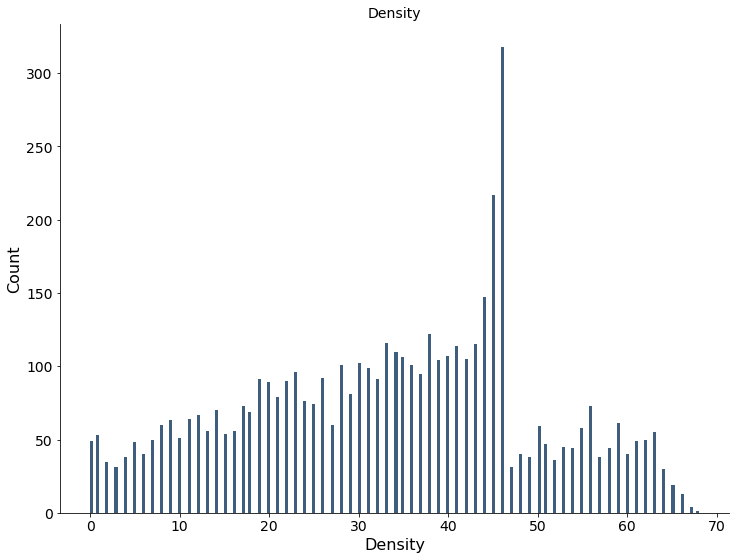

In [42]:

plt.figure(figsize=(12, 9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title("Density", fontsize=14)  

plt.xlabel("Density", fontsize=16)  
plt.ylabel("Count", fontsize=16)  

pkg = plt.hist(D,  
         color="#3F5D7D", bins=200)  

plt.show()

In [ ]:
"""
Visualization of outliers
"""

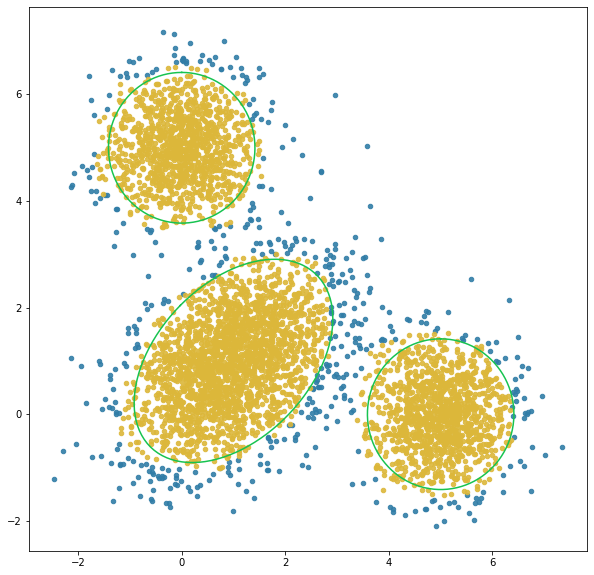

In [43]:
qry=int(np.percentile(D,10))

cond = (D>=qry)


for i,j in hdf.model.dim_combos[:1]:
    plt.figure(figsize=(10,10))

    plt.plot(X[~cond, 0], X[~cond, 1],'.', color='#317DA7', markersize=9, alpha=0.9, label='0-95th percentile')
    plt.plot(X[cond, 0], X[cond, 1],'.', color='#DCB73A', markersize=9, alpha=0.9, label='95-100th percentile')
    
plt_two_dev_clust()

plt.show()



In [77]:

"""
A More Difficult Problem...

As the input space increases in dimensionality, the Euclidean space between data points increases.
For an input space that contain only uniform random variables, the space between space points increase by
a factor of sqrt(D), where D is the number of dimensions.

"""

init_means = [
    [5, 0], # mean of cluster 1
    [1, 1], # mean of cluster 2
    [-5, 0]  # mean of cluster 3
]

init_covariances = [
    [[.5, 0.], [0, .5]], # covariance of cluster 1
    [[.92, .38], [.38, .91]], # covariance of cluster 2
    [[.5, 0.], [0, .5]]  # covariance of cluster 3
]
init_weights = [1/4., 1/2., 1/4.]  # weights of each cluster


Xtrain = np.vstack(generate_MoG_data(3000, init_means, init_covariances, init_weights))
Xtest = np.vstack(generate_MoG_data(500000, init_means, init_covariances, init_weights))

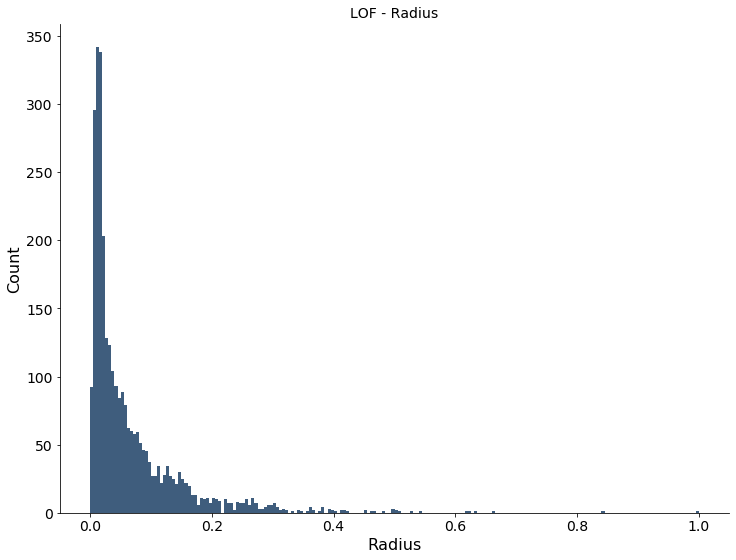

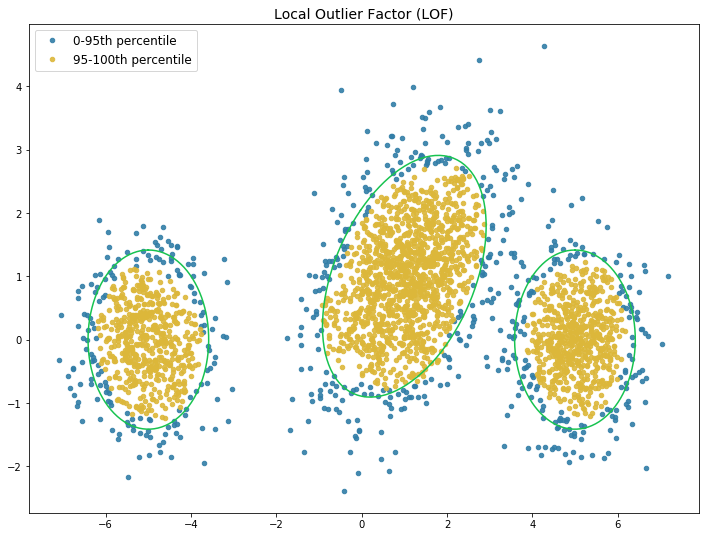

In [78]:

"""
Local Outlier Factor

The quality of the solution depends on the number of nearest neighbors and the contamination

"""

from sklearn.neighbors import LocalOutlierFactor

clf = LocalOutlierFactor(n_neighbors=100, contamination=0.2,novelty=True)
ypred = clf.fit(Xtrain).predict(Xtrain)
X_scores = clf.negative_outlier_factor_


radius = (X_scores.max() - X_scores) / (X_scores.max() - X_scores.min())
#while this provides some information on the level of density for each data point
#it is not availble when predicting on a new training dataset
# qry = np.percentile(radius,95)
# cond = radius>qry

plt.figure(figsize=(12, 9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title("LOF - Radius", fontsize=14)  

plt.xlabel("Radius", fontsize=16)  
plt.ylabel("Count", fontsize=16)  

pkg = plt.hist(radius,  
         color="#3F5D7D", bins=200)  

plt.show()


cond = ypred==1

plt.figure(figsize=(12,9))
plt.title("Local Outlier Factor (LOF)",fontsize=14)


plt.plot(Xtrain[~cond, 0], Xtrain[~cond, 1],'.', color='#317DA7', markersize=9, alpha=0.9, label='0-95th percentile')
plt.plot(Xtrain[cond, 0], Xtrain[cond, 1],'.', color='#DCB73A', markersize=9, alpha=0.9, label='95-100th percentile')


plt_two_dev_clust()

plt.axis('tight')
legend = plt.legend(loc='upper left', prop={'size': 12})
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

plt.show()

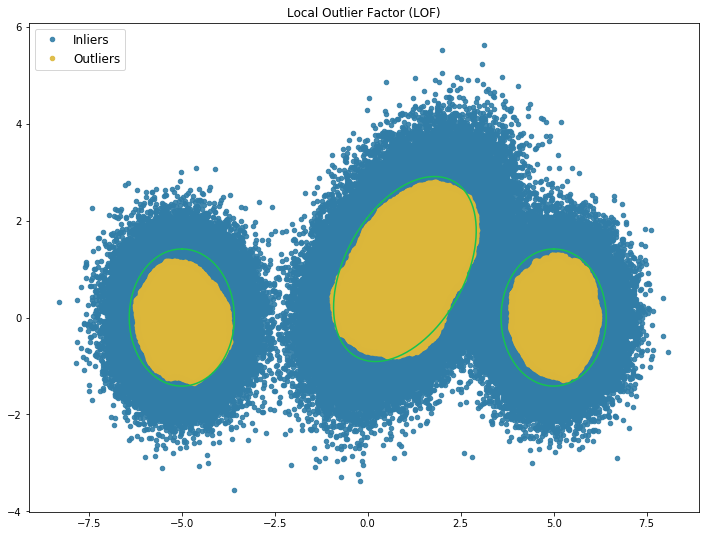

In [79]:
ypred = clf.predict(Xtest)

cond = ypred==1


plt.figure(figsize=(12,9))
plt.title("Local Outlier Factor (LOF)")


plt.plot(Xtest[~cond, 0], Xtest[~cond, 1], '.',color='#317DA7', markersize=9, alpha=0.9, label='Inliers')
plt.plot(Xtest[cond, 0], Xtest[cond, 1], '.', color='#DCB73A', markersize=9, alpha=0.9, label='Outliers')


plt_two_dev_clust()

plt.axis('tight')
legend = plt.legend(loc='upper left', prop={'size': 12})
legend.legendHandles[0]._sizes = [10]
legend.legendHandles[1]._sizes = [20]

plt.show()

In [1]:
"""
Compare with Hierarchical Density Factorization
"""

'\nCompare with Hierarchical Density Factorization\n'

In [80]:
hdf =  kernelml.region_estimator.HierarchicalDensityFactorization(num_clusters=16,
                                                                 bins_per_dimension=61,
                                                                 smoothing_parameter=1.,
                                                                 min_leaf_samples=int(Xtrain.shape[0]*0.05),
                                                                 alpha=0.5)

hdf.optimize(Xtrain,maxiter=12,realizations=10,number_of_random_simulations=100,verbose=True)

realization 0 loss 8.33997552340354 time 0.6424410343170166
realization 1 loss 7.088081140956626 time 0.6074690818786621
realization 2 loss 3.781847442696647 time 0.6180369853973389
realization 3 loss 2.7539457040545416 time 0.620253324508667
realization 4 loss 2.2263016331470467 time 0.6168177127838135
realization 5 loss 1.9892061313071365 time 0.5845990180969238
realization 6 loss 1.8098005702054305 time 0.5696010589599609
realization 7 loss 1.7449848049175398 time 0.5674350261688232
realization 8 loss 1.6830829978489084 time 0.5741500854492188
realization 9 loss 1.6671405141782862 time 0.566291093826294
1 clusters were not assigned data points

336 data points are unassigned
realization 0 loss 8.416667629741575 time 0.5748441219329834
realization 1 loss 5.9853701633151974 time 0.5748600959777832
realization 2 loss 5.3182298849938485 time 0.5785529613494873
realization 3 loss 5.059254531605831 time 0.6104729175567627
realization 4 loss 4.794241264591528 time 0.6428637504577637
realiz

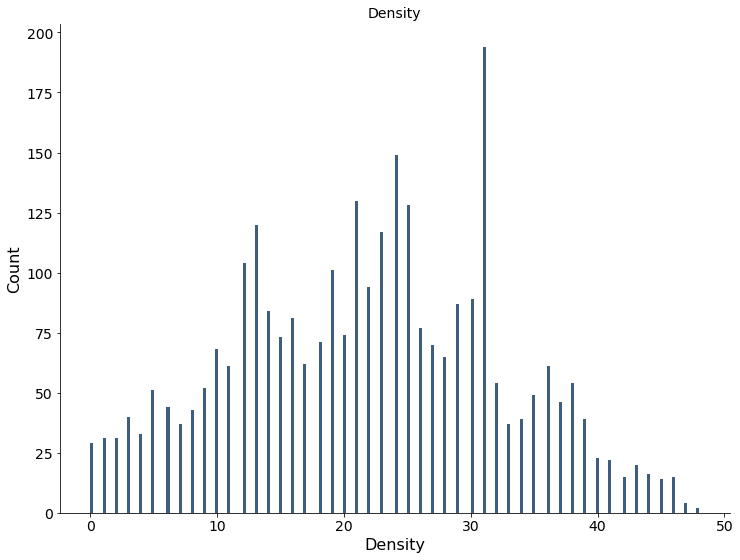

In [81]:
#assignments
A = hdf.assign(Xtrain)
#density
D = np.sum(A,axis=1)

plt.figure(figsize=(12, 9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title("Density", fontsize=14)  

plt.xlabel("Density", fontsize=16)  
plt.ylabel("Count", fontsize=16)  

pkg = plt.hist(D,  
         color="#3F5D7D", bins=200)  

plt.show()

In [82]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', len(np.unique(D)))
colors = np.linspace(0, 1, len(np.unique(D)))
colordict = dict(zip(np.unique(D), colors)) 
colormap = list(map(lambda x: colordict[x],D))

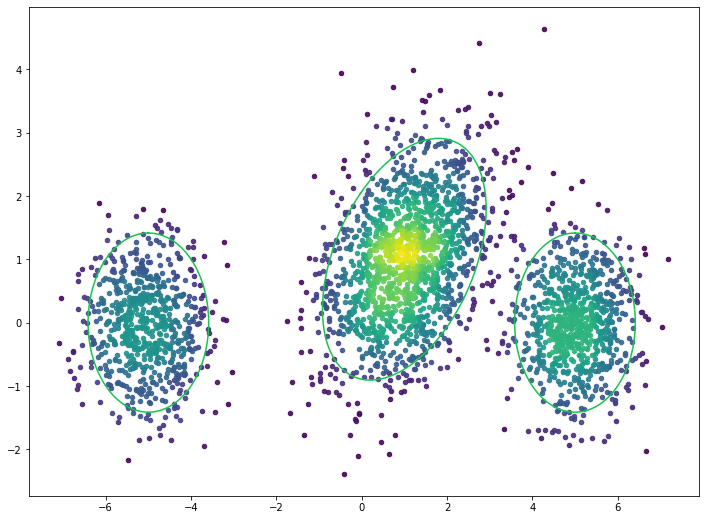

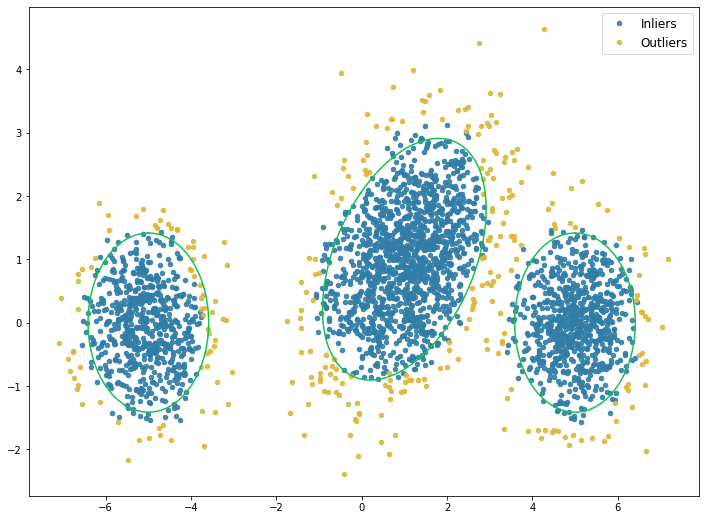

In [83]:
qry=int(np.percentile(D,10))
cond = (D>=qry)


plt.figure(figsize=(12,9))
for i,j in hdf.model.dim_combos[:1]:

    for c in colors:
        plt.plot(Xtrain[(colormap==c),i],Xtrain[(colormap==c),j],'.',c=viridis(c),alpha=0.9, markersize=9)

plt_two_dev_clust()
plt.show()

plt.figure(figsize=(12,9))    
for i,j in hdf.model.dim_combos[:1]:

    plt.plot(Xtrain[cond,i],Xtrain[cond,j],'.',color='#317DA7',alpha=0.9, markersize=9, label='Inliers')
    plt.plot(Xtrain[~cond,i],Xtrain[~cond,j],'.',color='#DCB73A',alpha=0.9, markersize=9, label='Outliers')
    
plt.legend( prop={'size': 12})
plt_two_dev_clust()
plt.show()




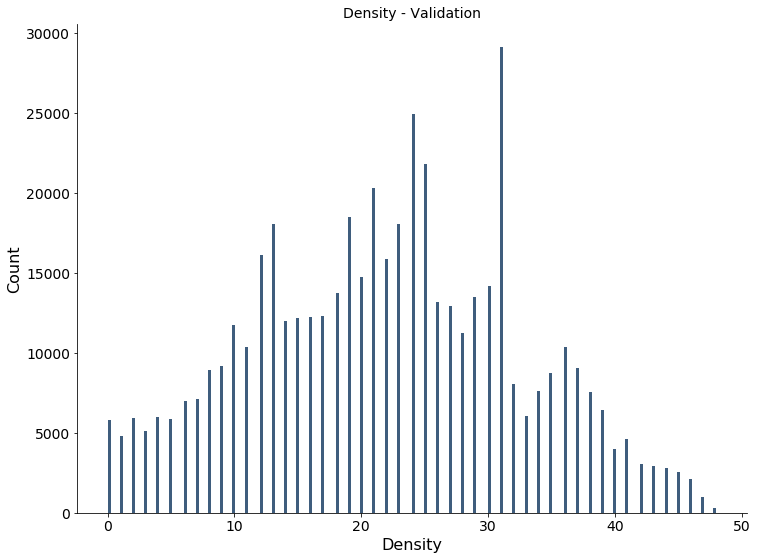

In [84]:
#assignments
A = hdf.assign(Xtest)
#density
D = np.sum(A,axis=1)

plt.figure(figsize=(12, 9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title("Density - Validation", fontsize=14)  

plt.xlabel("Density", fontsize=16)  
plt.ylabel("Count", fontsize=16)  

pkg = plt.hist(D,  
         color="#3F5D7D", bins=200)  

plt.show()

In [85]:
viridis = cm.get_cmap('viridis', len(np.unique(D)))
colors = np.linspace(0, 1, len(np.unique(D)))
colordict = dict(zip(np.unique(D), colors)) 
colormap = list(map(lambda x: colordict[x],D))

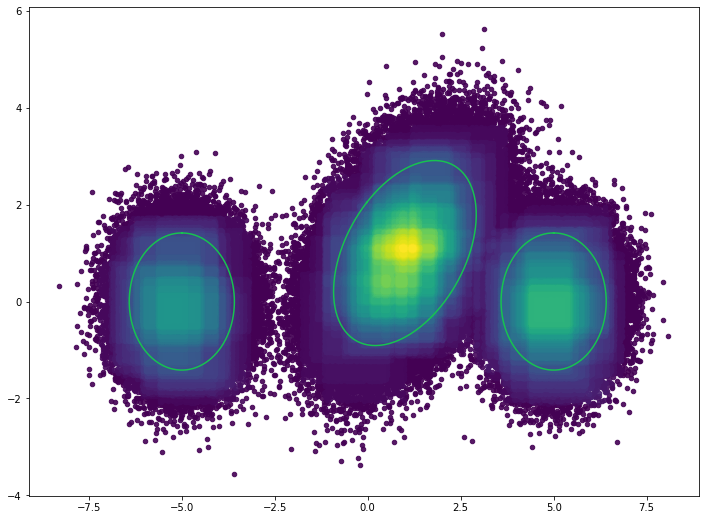

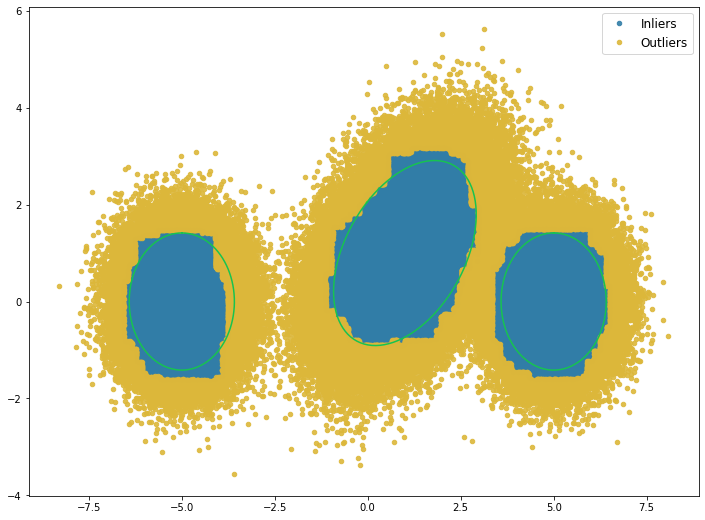

In [86]:
qry=int(np.percentile(D,10))
cond = (D>=qry)


plt.figure(figsize=(12,9))
for i,j in hdf.model.dim_combos[:1]:

    for c in colors:
        plt.plot(Xtest[(colormap==c),i],Xtest[(colormap==c),j],'.',c=viridis(c),alpha=0.9, markersize=9)

plt_two_dev_clust()
plt.show()

plt.figure(figsize=(12,9))    
for i,j in hdf.model.dim_combos[:1]:

    plt.plot(Xtest[cond,i],Xtest[cond,j],'.',color='#317DA7',alpha=0.9, markersize=9, label='Inliers')
    plt.plot(Xtest[~cond,i],Xtest[~cond,j],'.',color='#DCB73A',alpha=0.9, markersize=9, label='Outliers')
    
plt.legend(prop={'size':12})
plt_two_dev_clust()
plt.show()

In [ ]:
"""
Multi-dimensional example using the Pokemon dataset. 

Dataset properties:

All the features are continuous
Dimensionality is reduced with PCA prior to fitting density
"""

In [67]:
import re
df = pd.read_csv('data/Pokemon.csv').fillna('')
types = np.concatenate([df['Type 1'].unique(),df['Type 2'].unique()])
df['Type']=df[['Type 1','Type 2']].apply(lambda x: str(x[0])+str(x[1]),axis=1)
df.drop(['Type 1','Type 2'],axis=1,inplace=True)
df['Mega'] = df.Name.apply(lambda x: len(re.findall('Mega',x))>0).astype(np.int)

features = np.array(['HP', 'Attack', 'Defense', 'Sp. Atk', 'Sp. Def','Speed'])

Xtrain = df[features].fillna(0).values.astype(np.float64)

from sklearn import decomposition, preprocessing

pca = decomposition.PCA(4)

sclr = preprocessing.StandardScaler()

Xtrain_t = pca.fit_transform(sclr.fit_transform(Xtrain))

In [69]:
hdf =  kernelml.region_estimator.HierarchicalDensityFactorization(num_clusters=16,
                                                                 bins_per_dimension=61,
                                                                 smoothing_parameter=1.,
                                                                 min_leaf_samples=8,
                                                                 alpha=0.5)


hdf.optimize(Xtrain_t,maxiter=15,realizations=15,number_of_random_simulations=100,verbose=True)



realization 0 loss 173.23564262807295 time 0.9835562705993652
realization 1 loss 123.76858337377918 time 0.9137170314788818
realization 2 loss 100.85835072732775 time 0.8915719985961914
realization 3 loss 60.72495036302044 time 0.8970518112182617
realization 4 loss 39.26995313125481 time 0.8862149715423584
realization 5 loss 29.206706615593138 time 0.950131893157959
realization 6 loss 24.944778946544915 time 0.8692512512207031
realization 7 loss 23.110306890095995 time 0.9274177551269531
realization 8 loss 21.418707528483928 time 0.9440310001373291
realization 9 loss 20.177443855098005 time 0.963615894317627
realization 10 loss 18.345915275444202 time 0.955888032913208
realization 11 loss 17.42738276796491 time 0.9680500030517578
realization 12 loss 16.35440990333373 time 0.9181199073791504
realization 13 loss 15.89024219278378 time 0.9924399852752686
realization 14 loss 15.42269572771456 time 1.009429931640625
0 clusters were not assigned data points

216 data points are unassigned
re

realization 4 loss 32.65125912415219 time 1.1754889488220215
realization 5 loss 28.41231790038721 time 1.2163150310516357
realization 6 loss 26.976225270370595 time 1.2214829921722412
realization 7 loss 24.08157719131345 time 1.0486419200897217
realization 8 loss 22.006166815891604 time 0.9963321685791016
realization 9 loss 21.187695194101952 time 0.9893901348114014
realization 10 loss 20.715708173110954 time 1.0574920177459717
realization 11 loss 20.362310633910145 time 1.150846004486084
realization 12 loss 19.24004590145596 time 1.1140079498291016
realization 13 loss 18.77460971682862 time 1.122318983078003
realization 14 loss 18.560142934530653 time 1.0320158004760742
0 clusters were not assigned data points

34 data points are unassigned
realization 0 loss 91.28901319186903 time 1.0208990573883057
realization 1 loss 64.03920483895709 time 1.0336010456085205
realization 2 loss 46.24732913851581 time 1.065674066543579
realization 3 loss 35.99263464718545 time 1.1520872116088867
reali

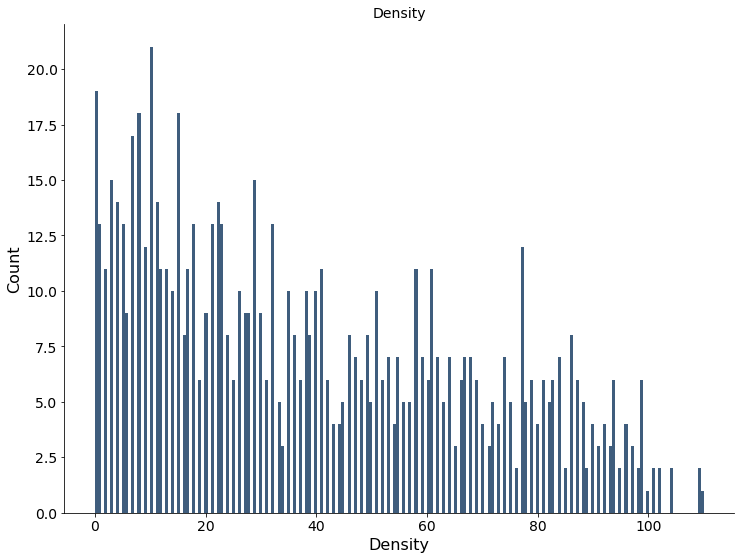

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type,Mega
121,113,Chansey,450,250,5,5,35,105,50,1,False,Normal,0
164,150,MewtwoMega Mewtwo Y,780,106,150,70,194,120,140,1,True,Psychic,1
217,202,Wobbuffet,405,190,33,58,33,58,33,2,False,Psychic,0
223,208,Steelix,510,75,85,200,55,65,30,2,False,SteelGround,0
224,208,SteelixMega Steelix,610,75,125,230,55,95,30,2,False,SteelGround,1
230,213,Shuckle,505,20,10,230,10,230,5,2,False,BugRock,0
261,242,Blissey,540,255,10,10,75,135,55,2,False,Normal,0
321,297,Hariyama,474,144,120,60,40,60,50,3,False,Fighting,0
333,306,AggronMega Aggron,630,70,140,230,60,80,50,3,False,Steel,1
351,321,Wailord,500,170,90,45,90,45,60,3,False,Water,0


In [70]:
A = hdf.assign(Xtrain_t)
D = np.sum(A,axis=1)

plt.figure(figsize=(12, 9))  

ax = plt.subplot(111)  
ax.spines["top"].set_visible(False)  
ax.spines["right"].set_visible(False)  
  
ax.get_xaxis().tick_bottom()  
ax.get_yaxis().tick_left()  
  
# plt.ylim(63, 85)  
    
plt.xticks(fontsize=14)  
plt.yticks(fontsize=14)  

plt.title("Density", fontsize=14)  

plt.xlabel("Density", fontsize=16)  
plt.ylabel("Count", fontsize=16)  

pkg = plt.hist(D,  
         color="#3F5D7D", bins=200)  

plt.show()

df[D==0]

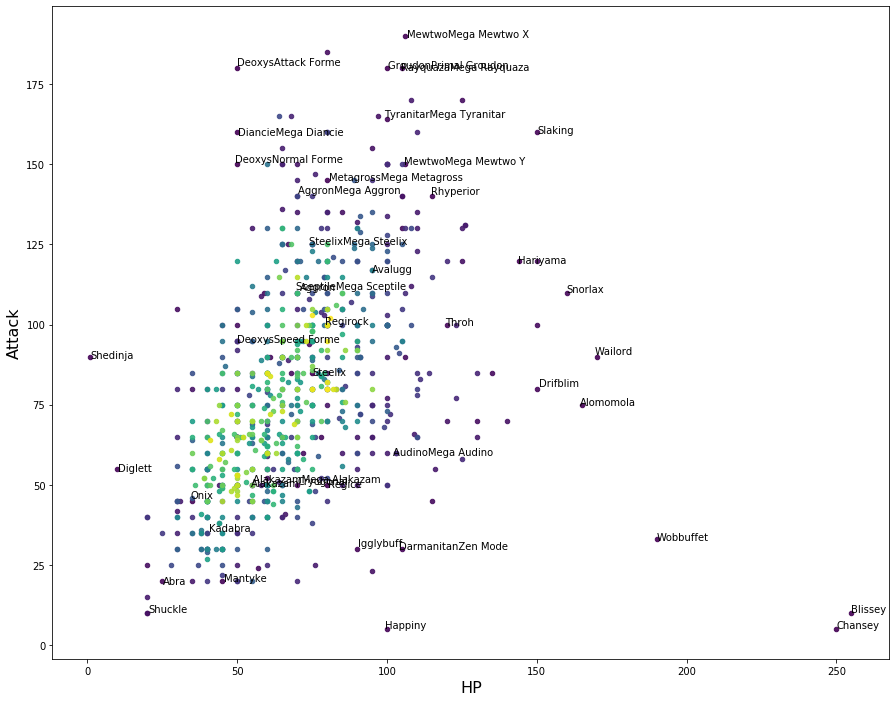

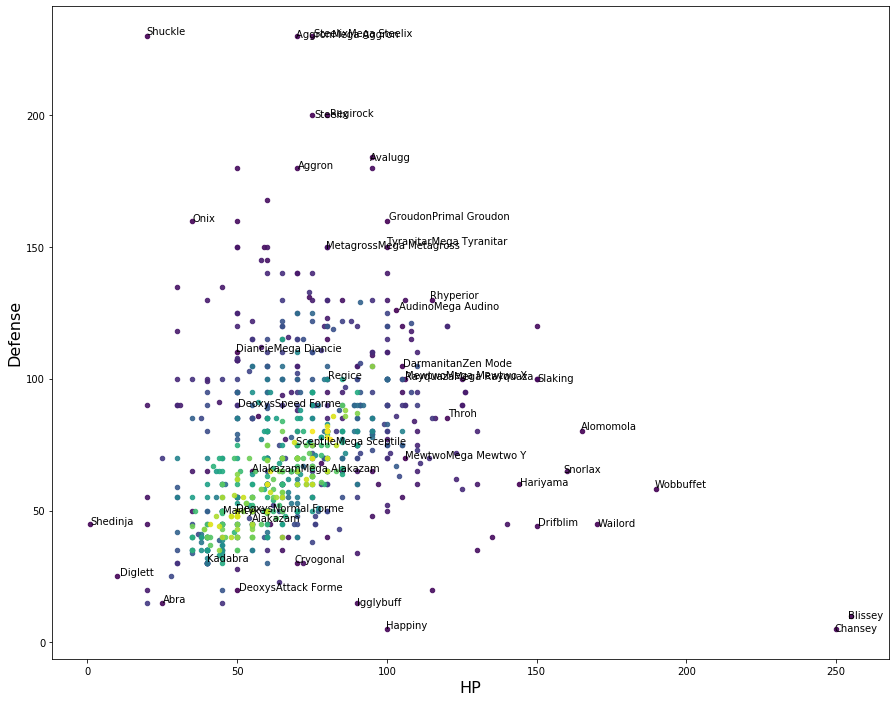

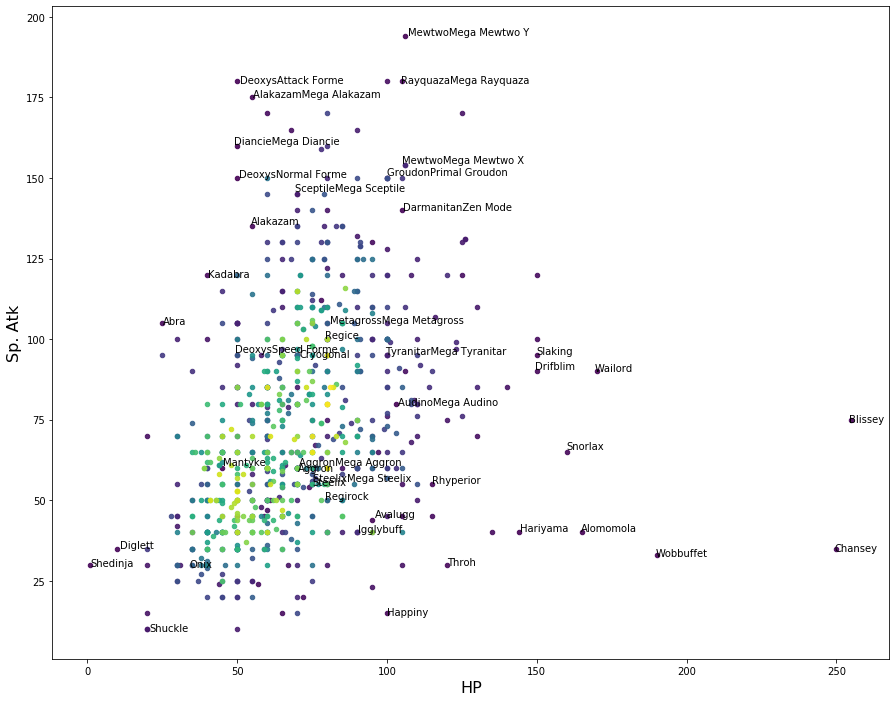

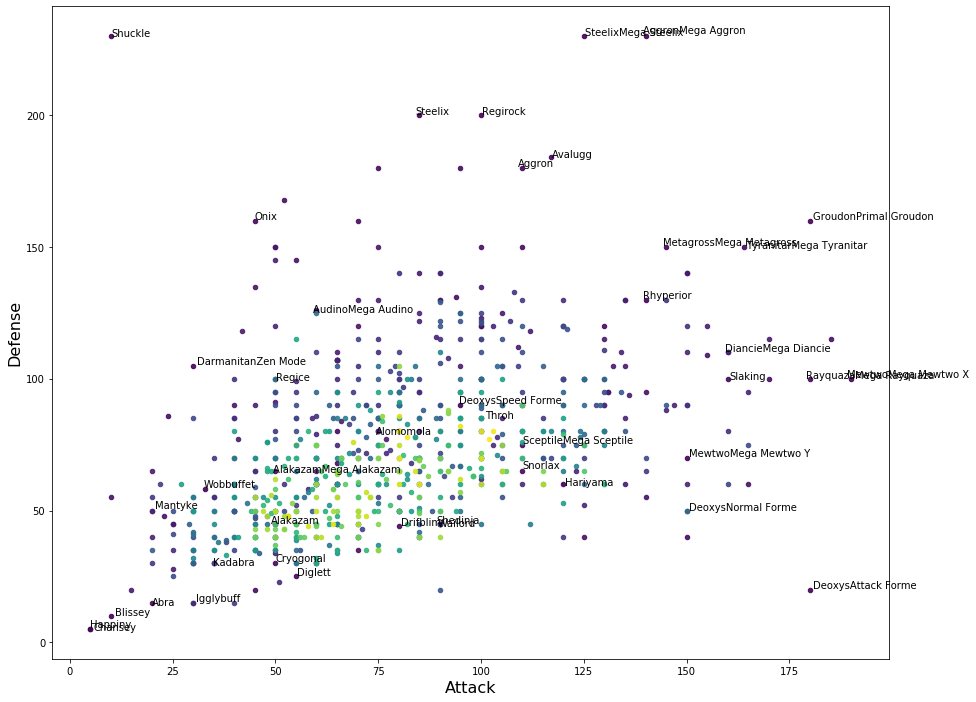

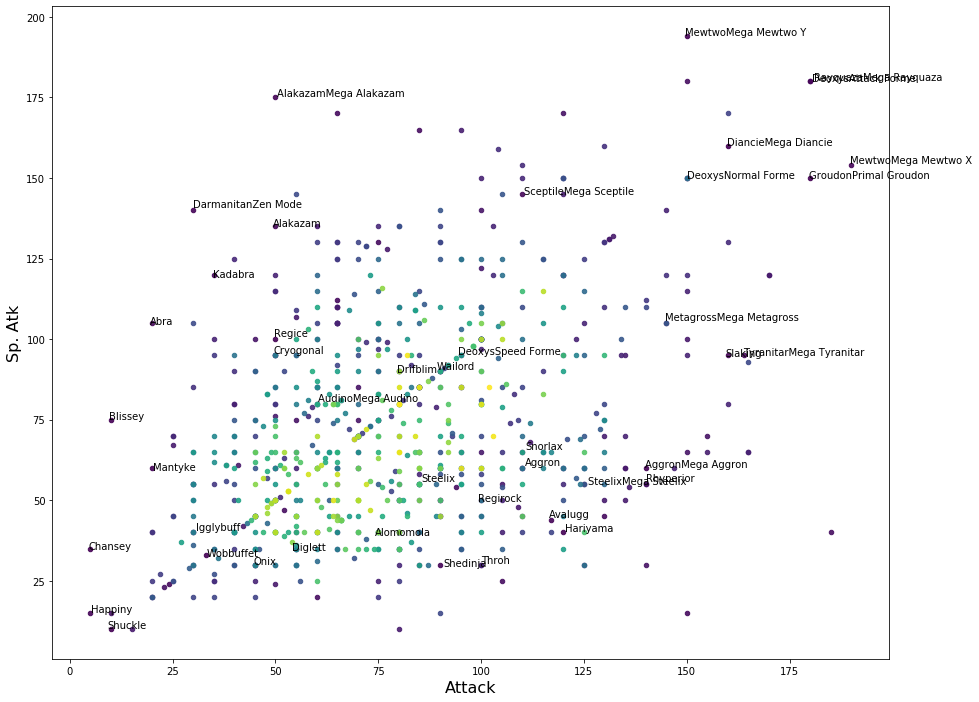

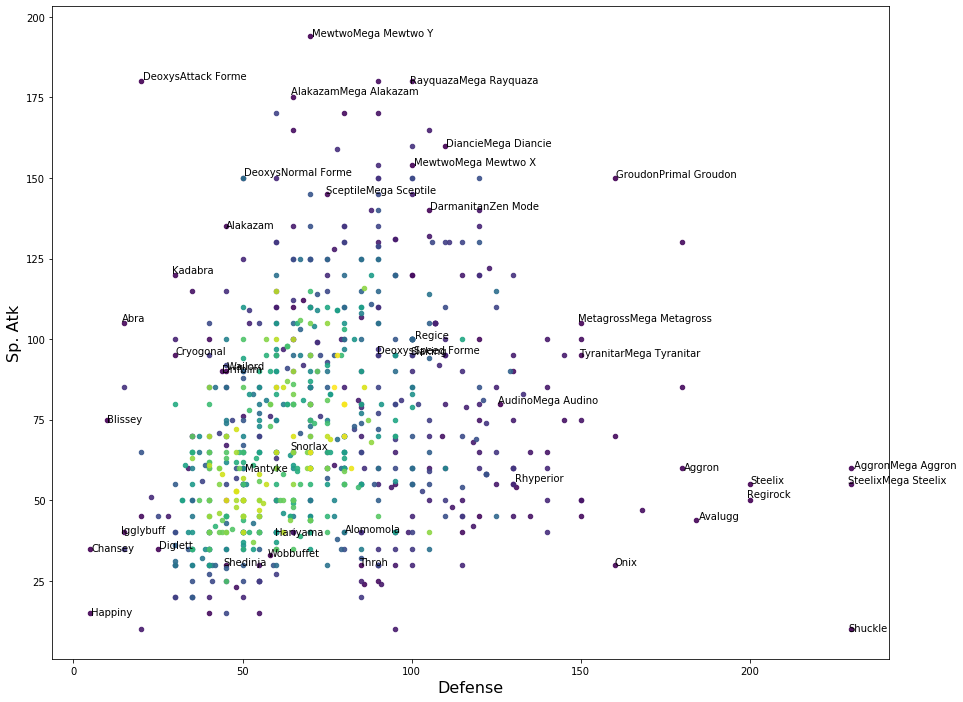

In [71]:
from matplotlib import cm
viridis = cm.get_cmap('viridis', len(np.unique(D)))
colors = np.linspace(0, 1, len(np.unique(D)))
colordict = dict(zip(np.unique(D), colors)) 
colormap = list(map(lambda x: colordict[x],D))


for i,j in hdf.model.dim_combos[:]:
    plt.figure(figsize=(15,12))
    for c in colors:
        plt.plot(Xtrain[(colormap==c),i],Xtrain[(colormap==c),j],'.',c=viridis(c),alpha=0.9, markersize=9)
        
    for z, txt in enumerate(df.Name.values.flatten()):
        if D[z]<=2:
            rand = np.random.uniform
            plt.annotate(txt, (Xtrain[z,i]+rand(-1,1), Xtrain[z,j]+rand(-1,1)),fontsize=10)
            
    plt.xlabel(features[i],fontsize=16)
    plt.ylabel(features[j],fontsize=16)
    plt.show()



In [2]:
"""
Compare with LOF
"""

'\nCompare with LOF\n'

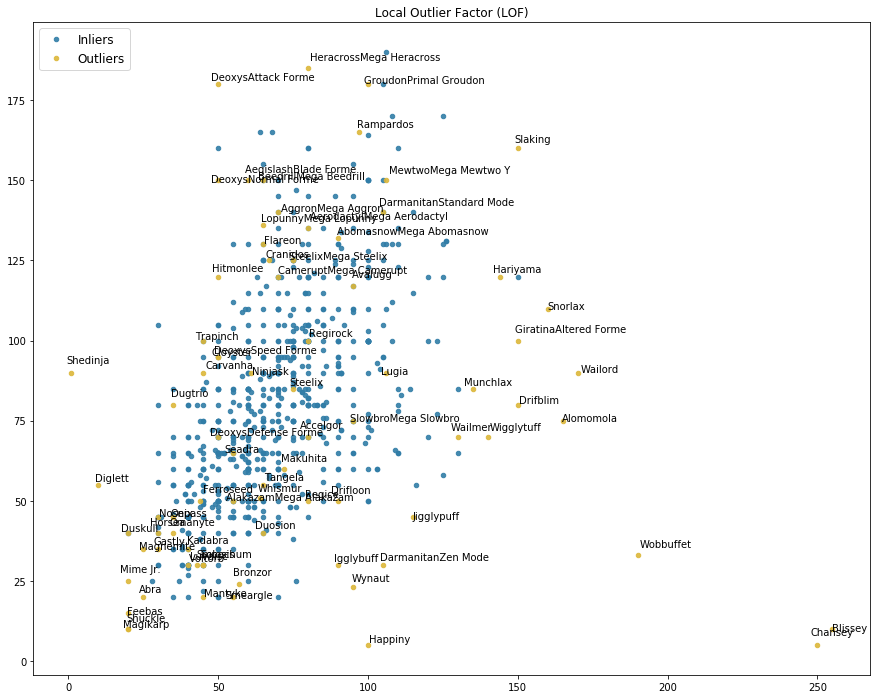

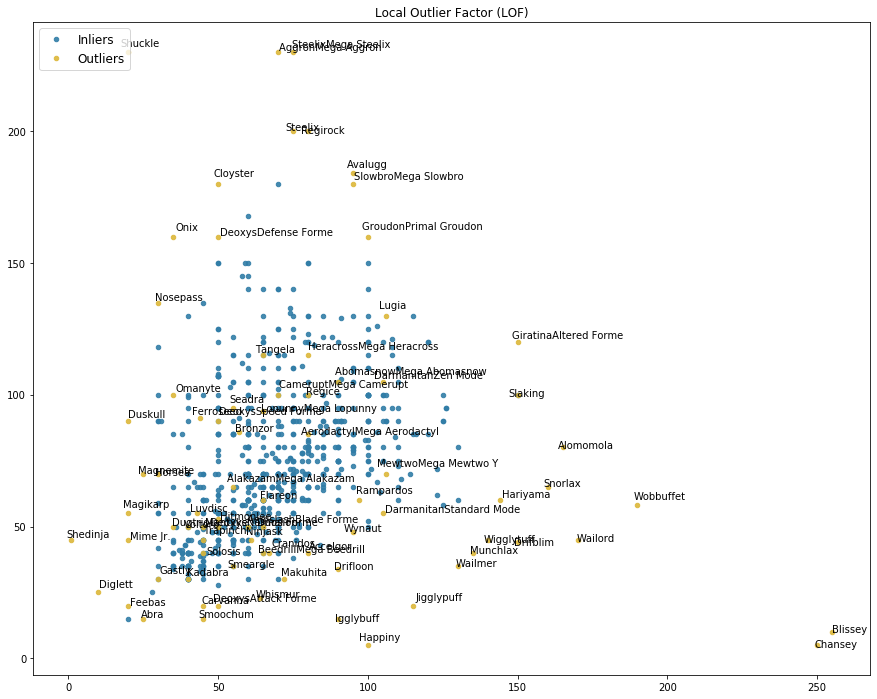

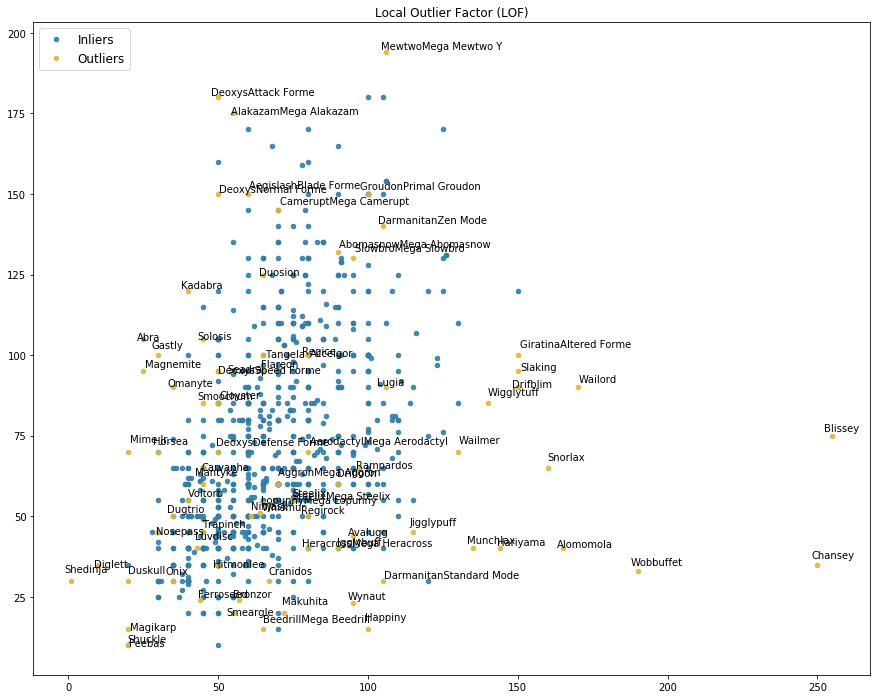

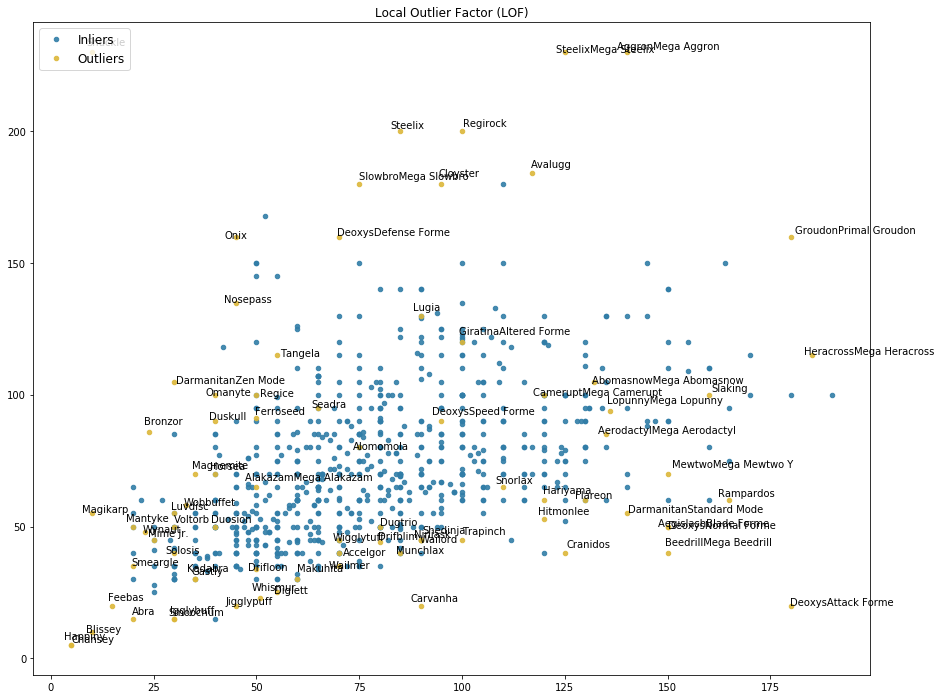

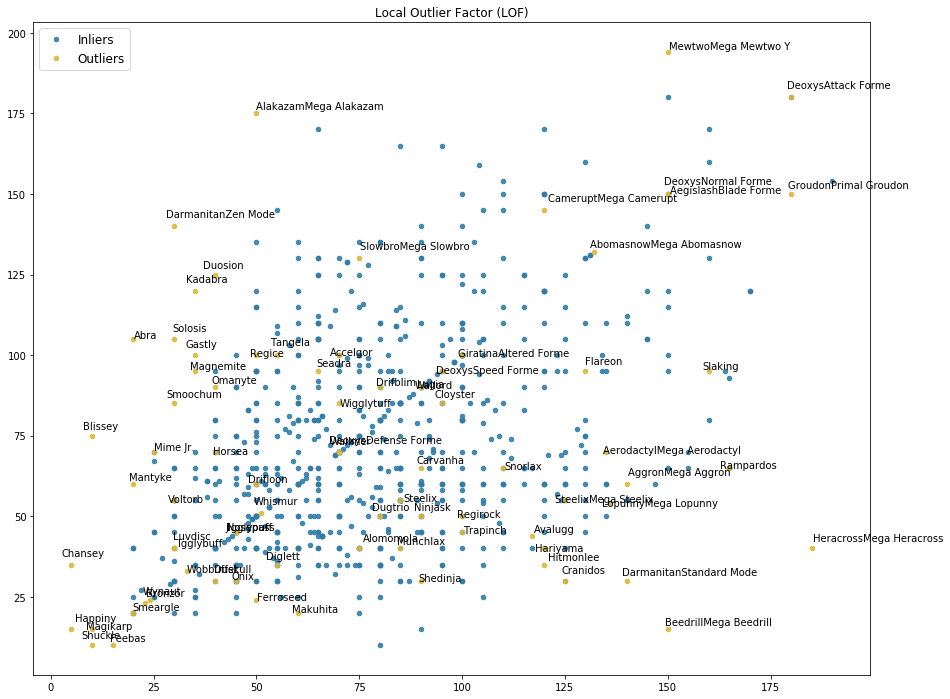

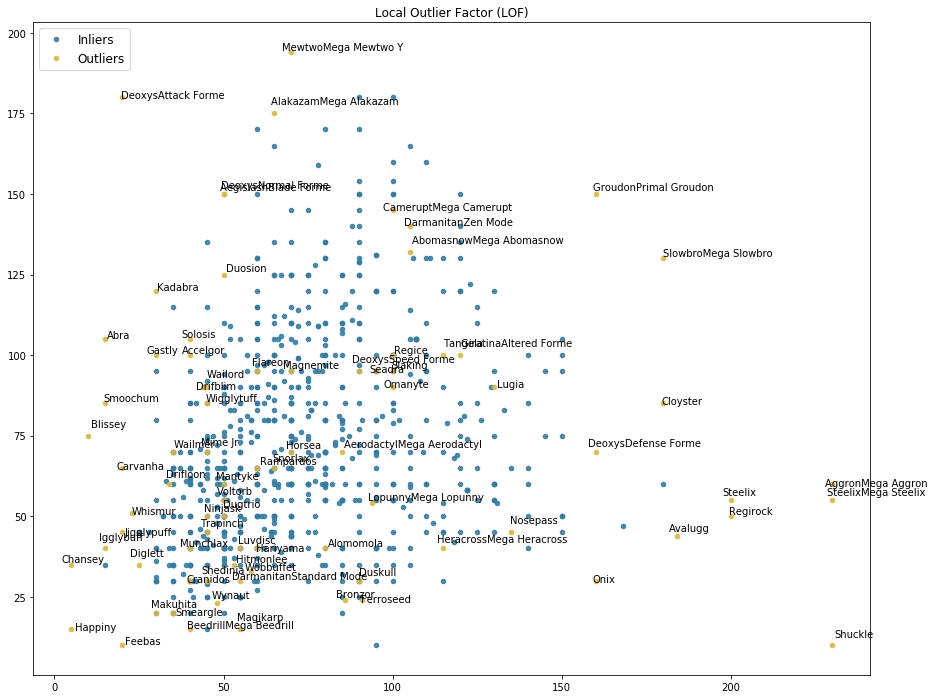

In [72]:
from sklearn.neighbors import LocalOutlierFactor


clf = LocalOutlierFactor(n_neighbors=20, contamination=0.1)
ypred = clf.fit_predict(Xtrain)
X_scores = clf.negative_outlier_factor_

cond = ypred==1

for i,j in hdf.model.dim_combos[:]:
    plt.figure(figsize=(15,12))
    plt.title("Local Outlier Factor (LOF)")
    plt.plot(Xtrain[cond,i],Xtrain[cond,j],'.',color='#317DA7',alpha=0.9, markersize=9, label='Inliers')
    plt.plot(Xtrain[~cond,i],Xtrain[~cond,j],'.',color='#DCB73A',alpha=0.9, markersize=9, label='Outliers')
    

    for z, txt in enumerate(df.Name.values.flatten()):
        if ypred[z]!=1:
            rand = np.random.uniform
            plt.annotate(txt, (Xtrain[z,i]+rand(-3,1), Xtrain[z,j]+rand(-1,3)),fontsize=10)
    # plot circles with radius proportional to the outlier scores

    # plt.scatter(y[:, 0], y[:, 1], s=1000 * radius, edgecolors='r',
    #             facecolors='none', label='Outlier scores')
    plt.axis('tight')
    # plt.xlim((-5, 5))
    # plt.ylim((-5, 5))
    # plt.xlabel("prediction errors: %d" % (n_errors))
    legend = plt.legend(loc='upper left', prop={'size':12})
    legend.legendHandles[0]._sizes = [10]
    legend.legendHandles[1]._sizes = [20]

In [73]:
hdf_cond = D<=2
lof_cond = ypred!=1

hdf_df = df[hdf_cond]
lof_df = df[lof_cond]

print('density factorization outlier count',hdf_df.shape[0])
print('local outlier factor count',lof_df.shape[0])
print('hdf and lof common outliers',hdf_df[['Name']].merge(lof_df[['Name']],on='Name',how='inner').shape[0])
print('outliers in hdf not in lof',hdf_df[~hdf_df.Name.isin(lof_df.Name)].shape[0])
print('outliers in lof not in hdf',lof_df[~lof_df.Name.isin(hdf_df.Name)].shape[0])

density factorization outlier count 43
local outlier factor count 80
hdf and lof common outliers 31
outliers in hdf not in lof 12
outliers in lof not in hdf 49


In [ ]:
"""
Compare outliers in the HDF solution and not in the LOF solution.

The results show that LOF missed a few important outliers.

"""

In [74]:
#in density factor not in local factor
hdf_df[~hdf_df.Name.isin(lof_df.Name)]

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type,Mega
70,65,Alakazam,500,55,50,45,135,95,120,1,False,Psychic,0
163,150,MewtwoMega Mewtwo X,780,106,190,100,154,100,130,1,True,PsychicFighting,1
268,248,TyranitarMega Tyranitar,700,100,164,150,95,120,71,2,False,RockDark,1
275,254,SceptileMega Sceptile,630,70,110,75,145,85,145,3,False,GrassDragon,1
332,306,Aggron,530,70,110,180,60,60,50,3,False,SteelRock,0
413,376,MetagrossMega Metagross,700,80,145,150,105,110,110,3,False,SteelPsychic,1
426,384,RayquazaMega Rayquaza,780,105,180,100,180,100,115,3,True,DragonFlying,1
515,464,Rhyperior,535,115,140,130,55,55,40,4,False,GroundRock,0
591,531,AudinoMega Audino,545,103,60,126,80,126,50,5,False,NormalFairy,1
598,538,Throh,465,120,100,85,30,85,45,5,False,Fighting,0


In [ ]:
"""
Compare outliers in the LOF solution and not in the HDF solution.

The results show that LOF labelled a few normal pokemon as outliers.

"""

In [75]:
#in local outlier factor not in density factor
lof_df[~lof_df.Name.isin(hdf_df.Name)]

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type,Mega
19,15,BeedrillMega Beedrill,495,65,150,40,15,80,145,1,False,BugPoison,1
44,39,Jigglypuff,270,115,45,20,45,25,20,1,False,NormalFairy,0
45,40,Wigglytuff,435,140,70,45,85,50,45,1,False,NormalFairy,0
56,51,Dugtrio,405,35,80,50,50,70,120,1,False,Ground,0
87,80,SlowbroMega Slowbro,590,95,75,180,130,80,30,1,False,WaterPsychic,1
88,81,Magnemite,325,25,35,70,95,55,45,1,False,ElectricSteel,0
98,91,Cloyster,525,50,95,180,85,45,70,1,False,WaterIce,0
99,92,Gastly,310,30,35,30,100,35,80,1,False,GhostPoison,0
108,100,Voltorb,330,40,30,50,55,55,100,1,False,Electric,0
114,106,Hitmonlee,455,50,120,53,35,110,87,1,False,Fighting,0


In [ ]:
"""
Compare specific cases
"""

In [76]:
#test sample in local outlier factor and not in density region
from sklearn import neighbors

KNN = neighbors.NearestNeighbors(n_neighbors=10)

qry = 154

KNN.fit(df[features].values)
ind =  KNN.kneighbors(df[features].values[qry:qry+1],return_distance=False)
df.loc[ind.flatten()]

,#,Name,Total,HP,Attack,Defense,Sp. Atk,Sp. Def,Speed,Generation,Legendary,Type,Mega
154,142,AerodactylMega Aerodactyl,615,80,135,85,70,95,150,1,False,RockFlying,1
476,428,LopunnyMega Lopunny,580,65,136,94,54,96,135,4,False,NormalFighting,1
716,648,MeloettaPirouette Forme,600,100,128,90,77,77,128,5,False,NormalFighting,0
700,639,Terrakion,580,91,129,90,72,90,108,5,True,RockFighting,0
512,461,Weavile,510,70,120,65,45,85,125,4,False,DarkIce,0
153,142,Aerodactyl,515,80,105,65,60,75,130,1,False,RockFlying,0
183,169,Crobat,535,85,90,80,70,80,130,2,False,PoisonFlying,0
527,475,GalladeMega Gallade,618,68,165,95,65,115,110,4,False,PsychicFighting,1
132,123,Scyther,500,70,110,80,55,80,105,1,False,BugFlying,0
493,445,Garchomp,600,108,130,95,80,85,102,4,False,DragonGround,0
